In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import os
from pathlib import Path

img_size = 224

The dataset has 3 different folder: - Traning - Test - Validation The first step is to extract every image from the training folder, and put them into an array, and, while saving them I am resizing every image in case they have different sizes. Every image was divided in 2 folders, (ALL --> Acute lymphoblastic leukemia, hem --> cells without leukemia), therefore I will asign a label to every image. Due to the large amount of data, there are another 3 folder inside the training directory, therefore I decided to use only one of them, for practical reasons and due to my pc performances.

In [2]:
labels = ['hem','all']
train_dir = 'training_data/fold_0'
train = []
for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        try:
            image_array = cv2.imread(os.path.join(path, img))
            resized_array = cv2.resize(image_array, (img_size,img_size))
            train.append([resized_array, class_num])
        except Exception as e:
            print(e)

Into the validaton folder, you can find a csv file with Patients ID and labels. You also will find, a second directory with the images of every observations of the previous file.

In [3]:
val = pd.read_csv('validation_data/C-NMC_test_prelim_phase_data_labels.csv')
x_val= []
for image_name in val.new_names:
    try:
        img = cv2.imread('validation_data/C-NMC_test_prelim_phase_data/' + image_name)
        img = cv2.resize(img, (img_size,img_size))
        x_val.append(img)
    except Exception as e:
        print(e)

y_val = val.labels.values

Here I am creating a simple countplot that represent the amount of images of cells affected and not affected by leukemia.

<AxesSubplot:ylabel='count'>

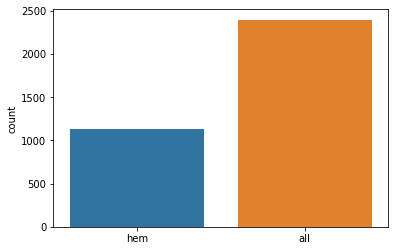

In [4]:
l = []
for i in train:
    if(i[1] == 1):
        l.append('all')
    else:
        l.append('hem')

sns.countplot(x=l)

Due to their similarity, I have decided to show only one of each cases.

Text(0.5, 1.0, 'hem')

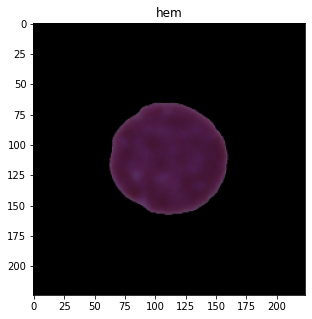

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'all')

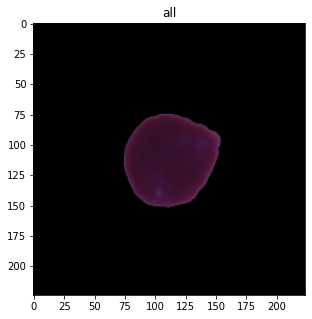

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

This step is dedicated to the pre-process of data: 
    - Dividing the training array into --> feaures and labels 
    - Normalizing the arrays containing the images (x_train = np.array(x_train)/255 --> in order to get values between 0 and 1)

In [4]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_train = np.array(x_train)/255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = np.array(x_val)/255
x_val.reshape(-1, img_size, img_size, 1)


array([], shape=(0, 224, 224, 1), dtype=float64)

For this model I've decided to use ImageGeneratorFunctio, to expand the training dataset in order to improve the performances of the model.

In [6]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

In this step I will define the CNN model layers. It has 5 hidden layers where it's filtering(Conv2D creates a feature map that summarizes of detected features, here I,m using relu as activation function) and pooling (MaxPool2D selects the maximum element from the feature map covered by the filter) every image. In every hidden layers there is a Dropout layer that helps prevent overfitting. Flatten converts the multi-dimensional image data array to 1d array.

In [4]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# Convolutional layer and maxpool layer 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# Convolutional layer and maxpool layer 3
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# Convolutional layer and maxpool layer 4
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# This layer flattens the resulting image array to 1D array
model.add(Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for Hem or 1 for All 
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

To compile the model I'm using Adam as optimizer and as loss function, binary crossentropy since there are only two classes.

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I did different tests with this model, with most of them I've set the epochs to 10, but I've also tried with 300 epochs because I was curious of the result.

In [ ]:
history = model.fit(x_train,y_train, epochs=300, validation_data=(x_val,y_val))

Epoch 1/10
111/111 [==============================] - 474s 4s/step - loss: 0.4593 - accuracy: 0.8064
Epoch 2/10
111/111 [==============================] - 397s 4s/step - loss: 0.4383 - accuracy: 0.8222
Epoch 3/10
111/111 [==============================] - 393s 4s/step - loss: 0.4233 - accuracy: 0.8251
Epoch 4/10
111/111 [==============================] - 388s 4s/step - loss: 0.4161 - accuracy: 0.8305
Epoch 5/10
111/111 [==============================] - 395s 4s/step - loss: 0.4131 - accuracy: 0.8259
Epoch 6/10
111/111 [==============================] - 380s 3s/step - loss: 0.3734 - accuracy: 0.8452
Epoch 7/10
111/111 [==============================] - 370s 3s/step - loss: 0.3535 - accuracy: 0.8614
Epoch 8/10
111/111 [==============================] - 361s 3s/step - loss: 0.3317 - accuracy: 0.8633
Epoch 9/10
111/111 [==============================] - 368s 3s/step - loss: 0.3023 - accuracy: 0.8758
Epoch 10/10
111/111 [==============================] - 402s 4s/step - loss: 0.2603 - accura

Here I am displaying on a graph the accuracy and the loss of the model over the epochs.

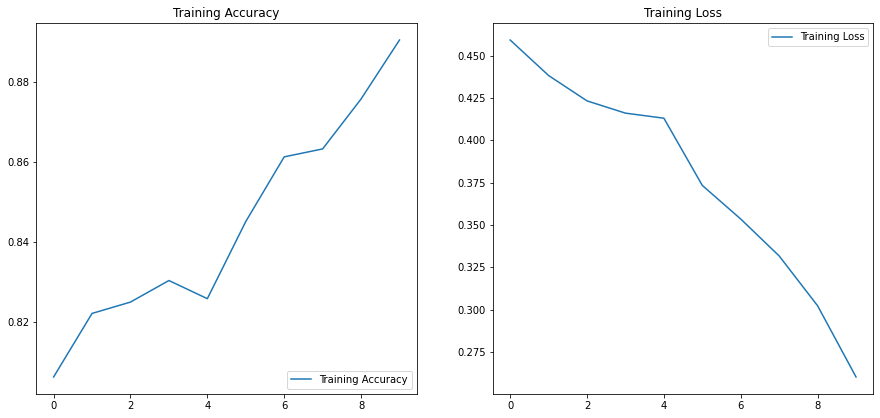

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(300)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [6]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19

model = VGG19()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,y_train, epochs=5, validation_data=(x_val,y_val))

574726144/574710816 [==============================] - 65s 0us/step
Epoch 1/5


ValueError: in user code:

    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Esteban\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 1000) vs (None, 1))
